In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
from openparticle import ParticleOperator
import numpy as np
import cirq
from src.lobe.system import System
from src.lobe.block_encoding import add_lobe_oracle
from cirq.contrib.svg import SVGCircuit
from src.lobe.usp import add_naive_usp
from src.lobe.rescale import rescale_terms, get_numbers_of_bosonic_operators_in_terms
from src.lobe._utils import get_basis_of_full_system
import openparticle as op

# Define Hamiltonian

In [8]:
bosonic_hamiltonian = (
    ParticleOperator("a0") + 
    ParticleOperator("a1") +
    ParticleOperator("a0^ a1") +
    ParticleOperator("a1^ a0")
)
terms = bosonic_hamiltonian.to_list()

maximum_occupation_number = 3
number_of_modes = max([term.max_mode() for term in terms]) + 1

full_fock_basis = get_basis_of_full_system(number_of_modes, maximum_occupation_number, has_bosons=True)
matrix = op.generate_matrix_from_basis(bosonic_hamiltonian, full_fock_basis)

eigenvalues, eigenvectors = np.linalg.eig(matrix)
print(sorted(eigenvalues.round(3)))

[-3.464, -3.0, -3.0, -2.0, -1.0, -1.0, 0.0, -0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 3.0, 3.0, 3.464]


# Rescale Hamiltonian

In [9]:
rescaled_terms, scaling_factor = rescale_terms(terms, maximum_occupation_number)
for term in rescaled_terms:
    print(term)

max_number_of_bosonic_ops_in_term = max(get_numbers_of_bosonic_operators_in_terms(terms))

0.5 * a0

0.5 * a1

1.0 * a0^ a1

1.0 * a1^ a0



# Generate LOBE Circuit

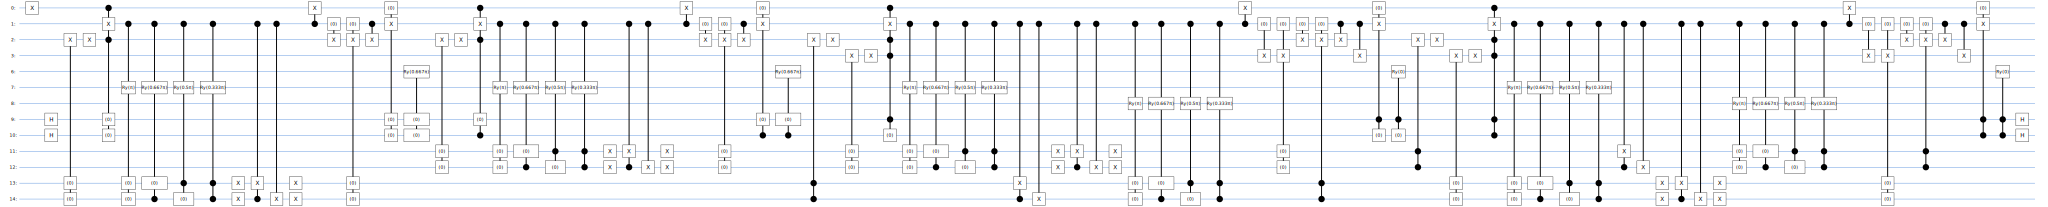

In [10]:
number_of_ancillae = 5
number_of_index_qubits = max(int(np.ceil(np.log2(len(terms)))), 1)
number_of_rotation_qubits = max_number_of_bosonic_ops_in_term + 1

# Declare Qubits
circuit = cirq.Circuit()
validation = cirq.LineQubit(0)
clean_ancillae = [cirq.LineQubit(i + 1) for i in range(number_of_ancillae)]
rotation_qubits = [
    cirq.LineQubit(i + 1 + number_of_ancillae)
    for i in range(number_of_rotation_qubits)
]
# rotation_qubits = [None] + rotation_qubits
index_register = [
    cirq.LineQubit(i + 1 + number_of_ancillae + 3)
    for i in range(number_of_index_qubits)
]
system = System(
    number_of_modes=number_of_modes,
    maximum_occupation_number=maximum_occupation_number,
    number_of_used_qubits=1 + number_of_ancillae + 3 + number_of_index_qubits,
    has_fermions=False,
    has_bosons=True,
)

# Generate full Block-Encoding circuit
circuit.append(cirq.X.on(validation))
circuit += add_naive_usp(index_register)
circuit += add_lobe_oracle(
    rescaled_terms,
    validation,
    index_register,
    system,
    rotation_qubits,
    clean_ancillae,
    perform_coefficient_oracle=True,
    decompose=False
)
circuit += add_naive_usp(index_register)

# with open("lobe.svg", "w") as f:
#     f.write(SVGCircuit(circuit)._repr_svg_())

SVGCircuit(circuit)

# Validate Block-Encoding

In [11]:
upper_left_block = circuit.unitary(dtype=complex)[
    : 1 << system.number_of_system_qubits, : 1 << system.number_of_system_qubits
]
block_encoding_scaling_factor = (1 << number_of_index_qubits)
assert np.allclose(upper_left_block * block_encoding_scaling_factor * scaling_factor, matrix)

### Overall Scaling Factor is:

$$
    S = 2^{\lceil \log_2{T} \rceil} * \max{|\alpha_i|} * (\Omega+1)^{B/2}
$$

where the variables are defined as follows:
- S: overall scaling factor of encoded Hamiltonian in block-encoding
- T: number of terms in Hamiltonian
- $\log_2{T}$: number of qubits used in index register
- $\alpha_i$: coefficient of term at index $i$
- $\max{|\alpha_i|}$: largest magnitude of all coefficients
- $\Omega$: maximum occupation number for bosonic modes
- $B$: maximum number of bosonic operators within a single term

In the code above, `scaling_factor` represents $\max{|\alpha_i|} * (\Omega+1)^{B/2}$ while `block_encoding_scaling_factor` represents $2^{\lceil \log_2{T} \rceil}$.